# A classification example: detecting breast cancer

In this notebook, we will look at data that is a bit more realistic than the examples from the lecture in the sense that it does come from real measurements. It is still 'easy', firstly, because the dataset is provided by sklearn in a nicely cleaned up version for tutorial purposes, and secondly because it is still considered a relatively simple problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn as sk
import sklearn.datasets
%matplotlib inline

# seed random generator such that it always returns the same random values 
# (for reproducability of results)
rng = np.random.RandomState(42)


## Load the data

In [2]:
# load the data
cancer = sk.datasets.load_breast_cancer()
# this data set is stored as a dictionary with many fields, 
# including a field called "DESCR" one that contains the information about the data set

print(cancer.DESCR)

# BTW, you can also print the whole data structure (uncomment the next instruction
# to see how all information about the data is stored into a dictionary: 

# print(cancer)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

In [3]:
# The features are stored in the field "data"
# and the desired labels are stored in the field "target"

X = cancer.data
target = cancer.target

# As is common, the feature matrix contains one row per training example
# By looking at its shape, we can see the number of examples and the number of features 
print(X.shape)
print(target.shape)

(569, 30)
(569,)


In [4]:
# Let's store the number of features and the number of samples for future use:

num_features = X.shape[1]
num_samples = X.shape[0]


## Step 1: data analysis

Obviously, you should first decide what type of problem you have: supervised or unsupervised, classification or regression (or ordinal regression), ... In this case, we have a supervised classification problem. 

Although this information is sufficient to be able to apply machine learning models for classification, it is never a good idea to do anything blindly. Instead, it is always a good idea to start with an exploration of the data you were given. The pandas library offers some wonderful support for doing this, as it was designed to analyse and visualise data properties. However, it uses its own data format (called a pandas DataFrame), so we first have to convert our current data to that format:


The next step is to figure out how many classes you have and whether or not the classes are (more or less) balanced. 

The next step is to look at the features in a bit more detail. You can look
for instance at the inter-feature correlations,
the individual feature distributions
or even for specific cases the joint distributions of some feature pairs,
or of features with the target

We will use the pandas library for this:

In [25]:
# Create a pandas DataFrame for the features
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)

# Add the target column
df['target'] = cancer.target

# Display the DataFrame
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


One thing that is immediately obvious from looking at the data is that the features have significantly different scales. This means that it will definitely be a good idea to normalise our features before allying a machine learning model!
The most commonn approach is to subtract the mean from each feature and divide it by its standard deviation. Be careful though: 
- the normalisation **is part of your model**
- therefore: **only** use mean/stdev **accross your training set** for normalisation!

Next, using pandas, we can start visualising the data:

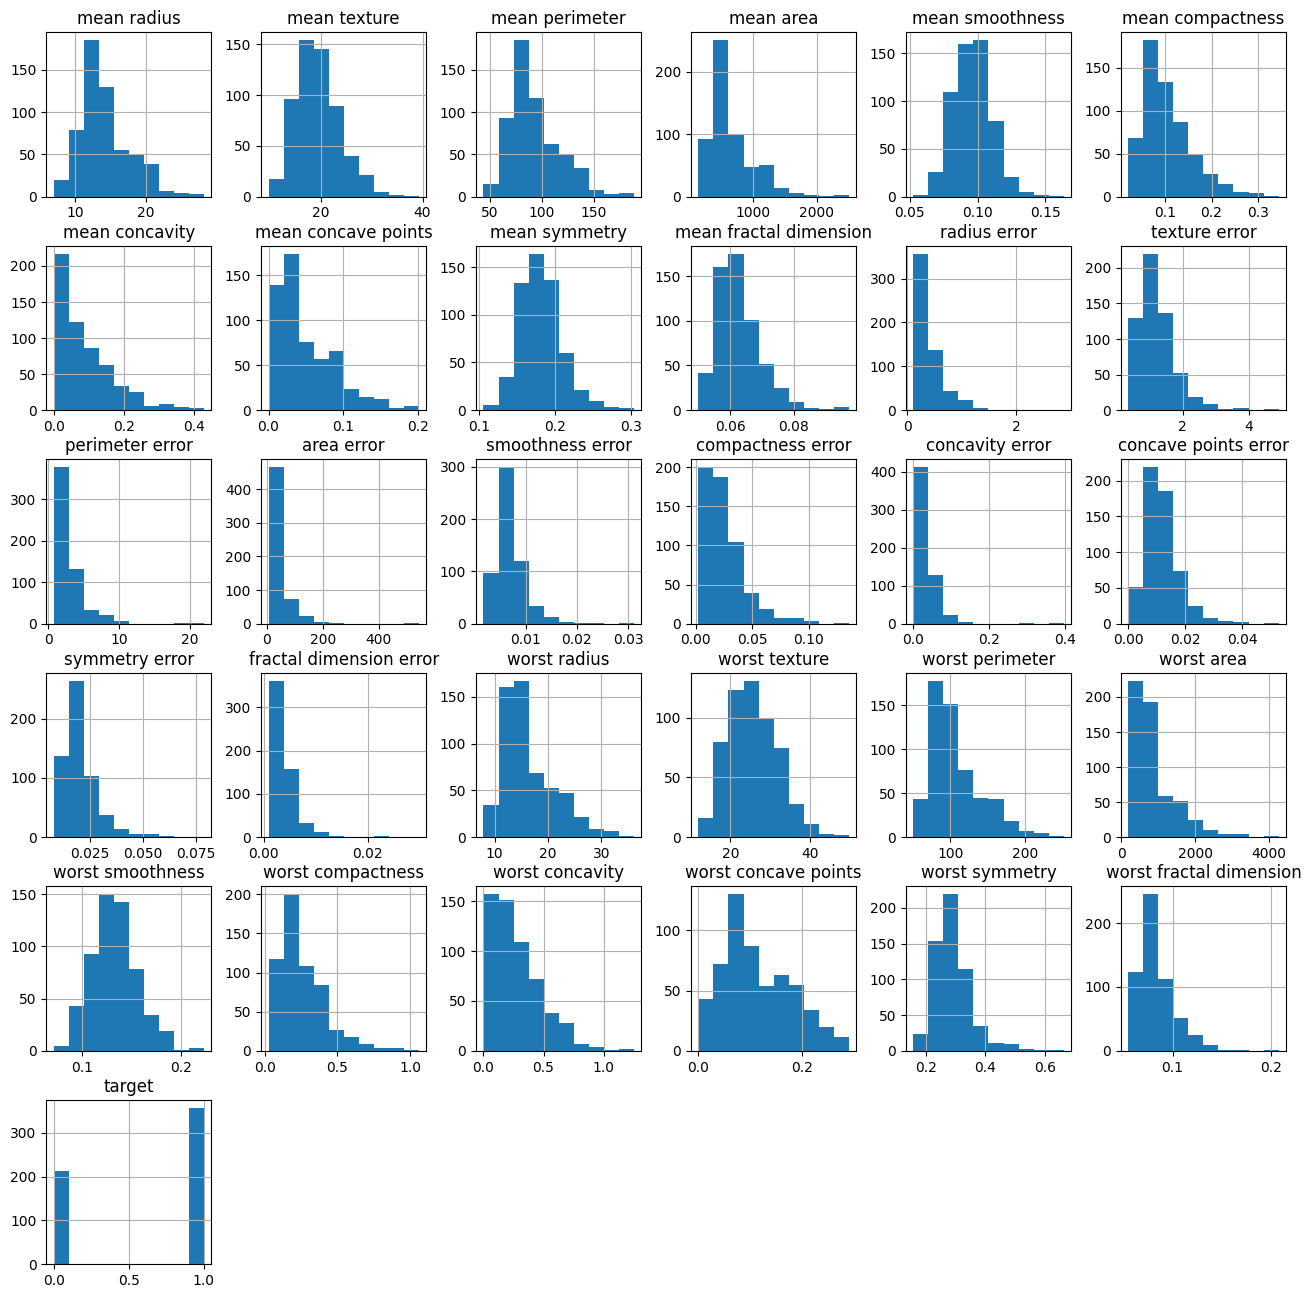

In [26]:
# Now we can use all the nice visualisation tools from pandas
# For instance, we can plot the feature histograms:

pd_data.hist(figsize = (16,16)) # figsize: (width,height)
plt.show()

What we can see from such plots is, for instance, that some of the distributions have a long tail and that some values might be outliers. In extreme cases, or based on domain knowledge about what would be realistic values, we might consider removing some outliers. When your model does not perform as good as we would hope, it is also a good idea to have a better look at these outliers. In this case, we will keep them. 

Looking at the histogram of the target values, we see something else: there is some imbalance in the labels, i.e., there are considerably more examples of class '1' than of class '0'. Since many models are sensitive to class imbalance, we should often take that into account. Most models in sklearn have the option to correct for class imbalance. **You should, however, think very hard for each separate machine learning problem you encounter about the question of whether you need to balance your classes. Think about the scoring metric you are optimizing for (and how to maximize/minimize its value), think about your choice of loss function, think about the class distribution of your training set, your validation set(s) and your test set ... What choices should you make here?**

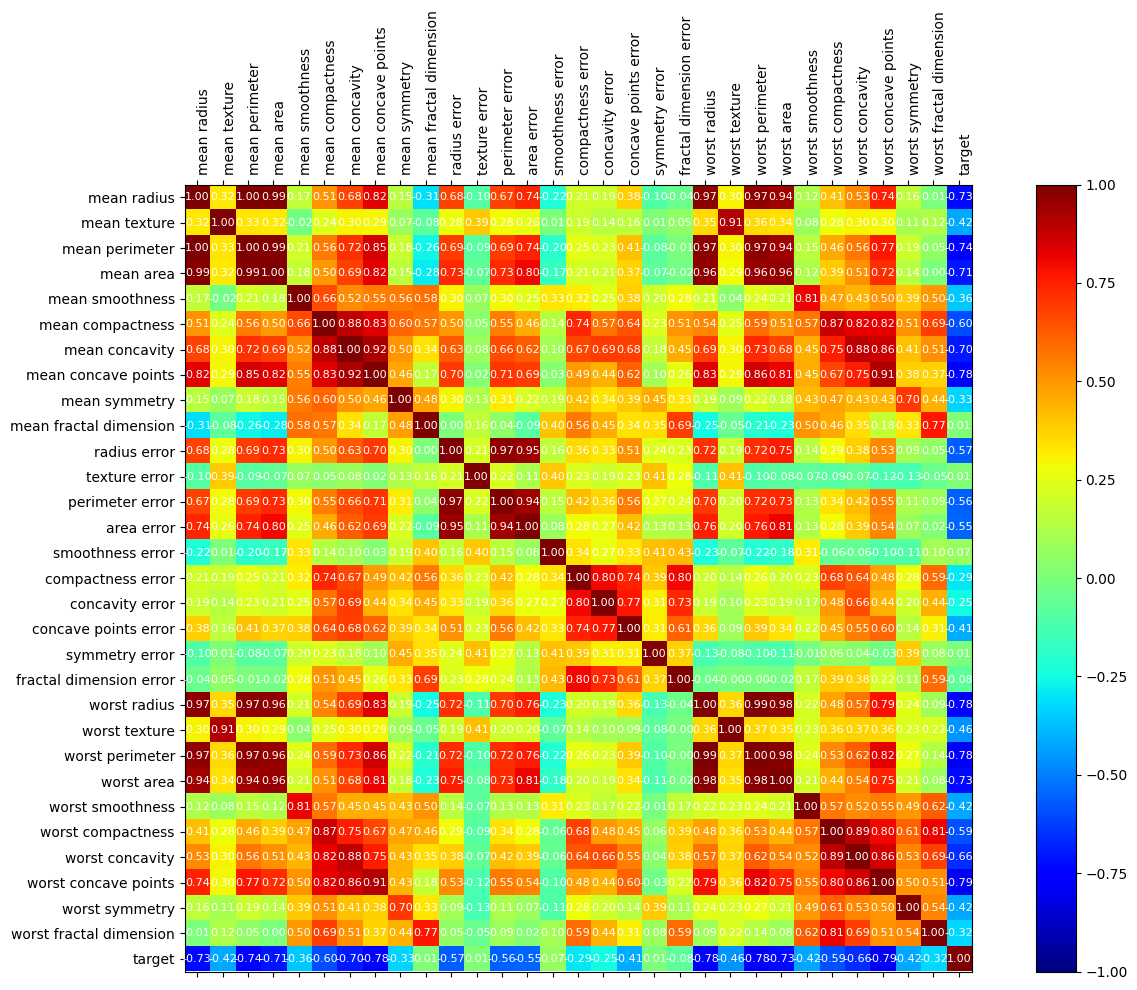

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_matrix(df):
    """Takes a pandas dataframe as input and plots the correlation matrix with values."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,10))
    corr = df.corr()  # Calculate the correlation matrix

    # Create the heatmap
    cax = ax.matshow(corr, vmin=-1, vmax=1, cmap='jet')

    # Add ticks for the columns
    ticks = list(range(len(df.columns)))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    # Set labels for ticks
    ax.set_xticklabels(df.columns, rotation=90, horizontalalignment='left')
    ax.set_yticklabels(df.columns)

    # Add color bar
    fig.colorbar(cax, ticks=[-1.0,-0.75,-0.5,-0.25,0.0,0.25,0.5,0.75,1.0])

    # Annotate the correlation values inside the heatmap
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='white', fontsize=8)
            
    plt.tight_layout()
    plt.show()

# Example usage with a dataset
plot_correlation_matrix(pd_data)


Now, what can we learn from this? Features that are strongly correlated (correlation value close to 1) mostly contain the same information. The same is true for features that are strongly anticorrelated (correlation value close to -1). We can clearly see that all features related to perimiter, radius and area are highly correlated. The same is true (although somewhat less obvious) for features related to compactness and concavity. Clearly, we will not need all the features to build our model, so in what follows, we will need to perform feature selection.

Note that the last row/column is not a feature but the labels. Here, high absolute values indicate features that will perform well in a linear model. Note that a low value does not necessarily mean that this feature contains no information, only that it might not have a linear relationship with the labels.

Besides the correlation matrix, you can also look at pairwise scatter plots of the features using a scatterplot matrix. However, in this case there are so many features that you can't see much on this image. However, some scatter plots clearly show a strong correlation, which is in correspondence with what we saw from the correlation matrix.

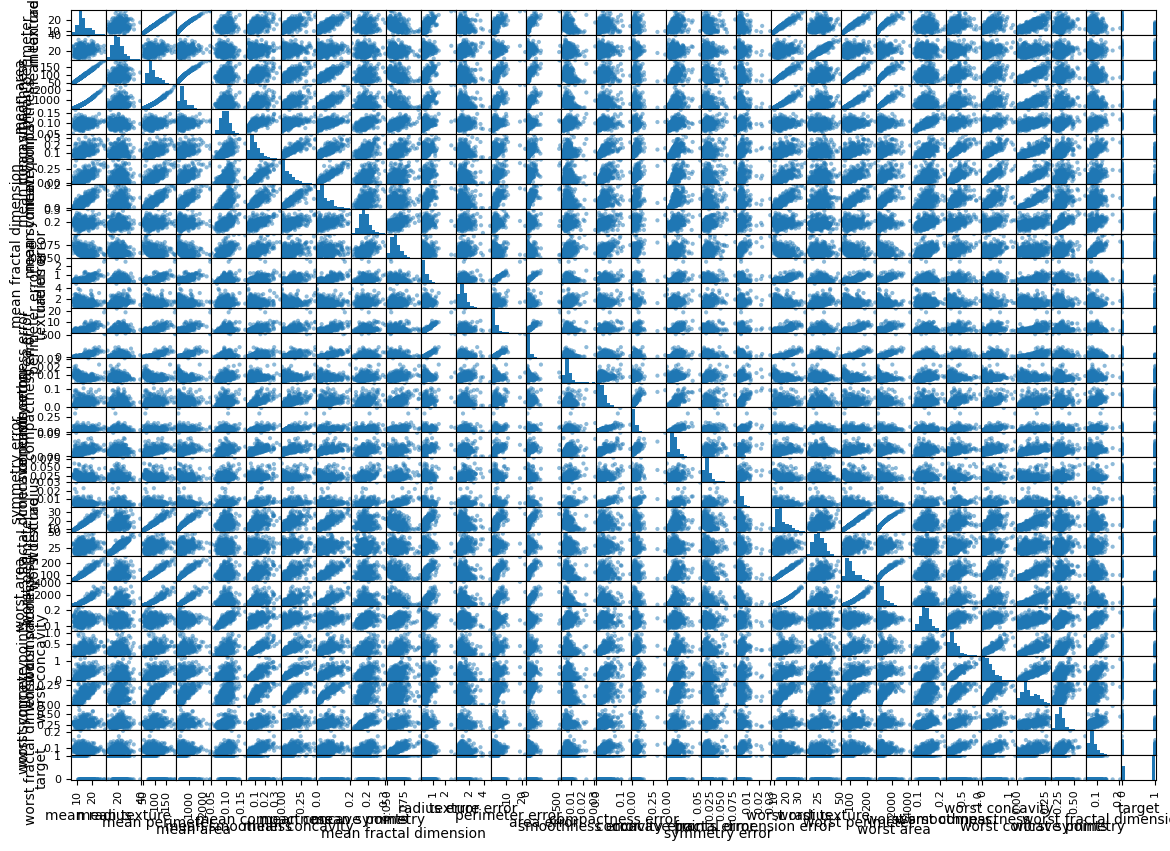

In [32]:
from pandas.plotting import scatter_matrix
scatter_matrix(pd_data,figsize = (14,10))
plt.show()

**Note:** as a result of data analysis, you may decide to do some preprocessing on the data. Possible steps are:

* dealing with missing or infinite values
* dealing with outliers of which you are certain they do not fall under 'normal variability' 
* removing some types of variability that are easy to remove: this may help you come up with a computationally simpler model, but keeping them will act as a regulariser!
* extracting transformed features from the original data

But be careful: doing these steps means you have to do the same steps later on unseen data! They therefore effectively become part of your model!

Since none of these steps are relevant for the data in this example, we will not discuss them further here.


## Step 2: validation set(s) and test set(s)

Machine learning models easily overfit to the training data. The result of overfitting is that the model doesn't generalise well, i.e., the model performance on unseen data is considerably worse than on the training data. For this reason, it is important to try and make a decent estimation of the performance on unseen data by splitting off a test set that is **not used at all** for building the model. 

We make the distinction between **training** and **tuning the hyperparameters**. E.g. in linear regression or logistic regression, training means optimising the weights for a given combination of model and training data. The hyperparameters are at a higher level than the weights; they include the feature set used, the regularisation parameter values, or generally anything that affects the model complexity. 

The best way to look at this is that each setting of hyperparameters corresponds to a different model and from all these possible settings, we want to pick the best (or at least a decent one). Again, a 'good' model is a model that performs well on **unseen** data, so we need to select our best hyperparameters based on data we haven't used for training.

Tuning many hyperparameters can also lead to overfitting. If we choose hyperparameters based on the test data, the score on this part of the data will again not be representative anymore for the score on completely unseen data. Therefore, we can not do the hyperparameter selection based on the test data. This is why we need to split the remaining data a second time into a **training set** and a **validation set**. 

If your test set is too small, your estimate of the generalization performance will not be reliable, if your validation set is too small, your selection of hyperparameters will be sub-optimal, because it's based on an unreliable estimate, and if you make both of these large, you don't have enough data left to train your model. If you have a lot of data relative to the task and model complexity this is no problem. However, in most cases, you don't have that amount of data. This is the reason we often use **cross-validation**: we split the data and optimise the model multiple times and average the model performance accross all runs to get a better estimate of the true validation score. Obviously, the amount of averaging you can afford greatly depends on the training time of each model and the computational resources you have at your disposal. In most cases, k-fold cross-validation is used. Here, the remaining training data is split into k equal parts (called **folds**) and the model is trained k times, each time using a different part as the validation set. The cross-validation score is the average model performance accross all k trained models, each evaluated on their validation set. Once the optimal hyperparameters are chosen, the model is retrained with **all** training data and then tested on the test set.

If you also need a more reliable test score, you can do nested cross validation by also considering multiple test sets, repeating the whole optimisation procedure for each test set and averaging the test scores. 

Although cross validation is well supported in sklearn and therefore sounds quite easy, this is also where many mistakes occur. In many real life situations, the data you have available for training is not really "i.i.d.". Instead, it comes from different subgroups, for instance, it may have been measured on different days or in different times of the year, originate from different test subjects, be collected by different enqueteurs, come from different customers or companies, ... and in most cases each of these subsets will have (hopefully slightly) different underlying distributions. Also, in most cases, you want your model to be robust against that, for instance, it should work with new patients or customers, or be useful to new companies. In that case, this is exactly what you need to evaluate during cross validation, by keeping entire subgroups within one fold and/or splitting off an entire subgroup in each test set. In addition, ideally, you are involved in the data collection: think about which differences may occur accross subgroups and really push having enough subgroups to allow your model to generalise beyond this. You can find more about cross-validation options on http://scikit-learn.org/stable/modules/cross_validation.html the sklearn documentation page </a>.  

Now back to our cancer data set. In this case, we have no additional information about possible subgroups in the data (e.g., the data might have been collected in different labs, by different lab assistants, or with slightly different measurement equipment). Therefore, the best we can do is randomly splitting the data into train and test sets and use cross-validation with random folds.

In [38]:
# Randomly split off a test set of approximatly 25% of the data
# Beware: this function does a RANDOM split (so it does shuffle the data before splitting)
# IF you also want to account for class imbalance, you should use the 'stratify' argument:
# train_test_split(X,target,test_size = test_fraction,stratify=target)
# this will enforce that (approximately) a fraction of 'test_fraction' 
# of EACH CLASS is split off  

from sklearn.model_selection import train_test_split

test_fraction = 0.25
x_train, x_test, r_train, r_test = train_test_split(X, target, test_size = test_fraction, random_state=0)

## Step 3: Training and optimising your first model

Now we are ready to build our first model using logistic regression. Note that you can repeat all the steps below for any model (linear or nonlinear) that is available in the sklearn library.

In [40]:
# step 1: import the model
from sklearn.linear_model import LogisticRegression

# step 2: create a model instance 
# (this is a model object that can be trained, tuned and used)

logreg0 = LogisticRegression(max_iter=10000)

# step 3: train the model on the training data

logreg0.fit(x_train, r_train)

# step 4: predict labels for test data 

pred0 = logreg0.predict(x_test)

# step 4: calculate the accuracy of the model on the train set and on the test set
# Note that each supervised model type in sklearn has a score() function 
# this always computes the inherent loss function for that model
# Always check the documentation to know what this returns!!!

train_score0 = logreg0.score(x_train, r_train)
test_score0 = logreg0.score(x_test, r_test)

print("Accuracy of first model: ",train_score0," (train), ",test_score0," (test)")

Accuracy of first model:  0.960093896713615  (train),  0.951048951048951  (test)


Now, we established two things during our data analysis: 
- the ranges of the features are far apart
- the classes are slightly imbalanced

In order to see how this affects our model, we need to normalise the **training** data and tell the model to compensate for class imbalance.

In addition, now that we start comparing models, we should do cross-validation! So let's introduce that first:

In [41]:
from sklearn.model_selection import cross_val_score

# Be careful here: the code below performs 5-fold cross validation with random fold splits!!

scores0 = cross_val_score(logreg0, x_train, r_train, cv=5)
print(scores0)
print("Average validation accuracy: ", scores0.mean(), ",\nStdev of validation accuracies: ", scores0.std())

[0.98837209 0.94117647 0.91764706 0.97647059 0.96470588]
Average validation accuracy:  0.9576744186046511 ,
Stdev of validation accuracies:  0.025375013338864674


**An important note on validation schemes:** 

There are often reasons why we should NOT simply use random train-validate splits. If you only need to compensate for class imbalance, you can use the function:

sklearn.model_selection.StratifiedKFold

In more complex situations, e.g., when you need to keep subgroups of samples together, you will have to write code that gives you a vector of group numbers for each training sample. Each group then expresses a subset of training examples that must be kept together. This vector is then used as an additional input for the group version of k-fold:

sklearn.model_selection.GroupKFold

You can have many more groups than folds. The function above will then try to combine these groups into folds that are as balanced as possible.

Now remember that the average cross validation score is supposed to be an estimate of the test score and the test score is supposed to be an estimate of the performance on unseen data. We see that there is considerable variability of the validation scores of the different folds. This is because each of the five models is trained on a different data set **and** tested on a different data set. This reflects a combination of the **variance** of the model and the statistical variance due to the finite size of the validation set. Together, they reflect how unsure we are about the expected average model performance on unseen data.

Now, the second step is to normalise the data. There are multiple options (more info at http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py), but in this notebook, we will use the RobustScaler. Since this must be done **only** based on the training data, the normalisation is effectively part of the model. In sklearn, this can be done efficiently by building a **pipeline**, i.e. chaining functions together into one model.

In [12]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler

simple_pipe = make_pipeline(RobustScaler(quantile_range=(25, 75)),LogisticRegression())

scores1 = cross_val_score(simple_pipe, x_train, r_train, cv=5)
print(scores1)
print("Average validation accuracy: ",scores1.mean(),", stdev: ",scores1.std())

[0.98837209 0.98823529 0.95294118 1.         0.98823529]
Average validation accuracy:  0.9835567715458277 , stdev:  0.015966583176422935


We see that rescaling has improved our model's accuracy. For one of our folds, the validation score has even gone up to 1! Now we want to check whether compensating for class imbalance helps. This is an optional parameter of the logistic regression model. Unfortunately, not all models have this option, so you may sometimes need to implement this yourself. You can do this either by changing the folds (e.g., by oversampling 'small' classes or undersampling 'large' classes)

In [13]:
balanced_pipe = Pipeline([
    ('scale',RobustScaler(quantile_range=(25, 75))),
    ('logreg',LogisticRegression(class_weight="balanced"))
])

scores2 = cross_val_score(balanced_pipe, x_train, r_train, cv=5)
print(scores2)
print("Average accuracy: ",scores2.mean(),", stdev: ",scores2.std())


[0.98837209 0.97647059 0.95294118 1.         0.98823529]
Average accuracy:  0.9812038303693571 , stdev:  0.015970614585569115


We see that, in this case, the improvement is not significant, which is not so surprising, since the class imbalance was not very large, but it also doesn't harm.

Now there is one more thing we need to do in order to wrap up our simple model: tune the regularisation hyperparameter. In fact, we actually should have done this from the beginning, but this is of course a simple tutorial.

Forgetting about hyperparameters is easy, since all hyperparameters are optional in sklearn. This doesn't mean they don't exist, only that they have been set to a default value. In the case of regularisation this usually means: no regularisation. 

In summary, you must always check your model's specs for regularisation parameters and you need to optimize the relevant ones!

There usually are quite a lot of optional parameters in sklearn models, and most of the ones that are not crucial for regularisation can safely be left at their default values. Often there are also a few parameters related to how the model is being trained. These usually trade-off computation time against quality. To be on the safe side: always check your options. For example, you can check the logistic regression documentation page here: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. In this study, we will leave the regularisation type at its default option (L2) but we need to check whether tuning the regularisation hyperparameter C (check the documentation for the interpretation) gives any improvement. The default value is C=1.

In [14]:
# Note that sweeping regularisation parameters is usually done on a logarithmic scale:
from sklearn.model_selection import GridSearchCV

balanced_pipe_regul = Pipeline([
    ('scale',RobustScaler(quantile_range=(25, 75))),
    ('logreg',LogisticRegression(C=1.0, class_weight="balanced"))
])


# Set the parameters by cross-validation
tuned_parameters = [{'logreg__C': [1.0e-5,1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0, 
                                   10.0, 100.0, 1000.0,10000.0]}]

CV = GridSearchCV(balanced_pipe_regul, tuned_parameters, cv=5)
CV.fit(x_train, r_train)

print("Best parameter set found on development set: ", CV.best_params_)
# store the best optimization parameter for later reuse
bestC2 = CV.best_params_['logreg__C']

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    

Best parameter set found on development set:  {'logreg__C': 1.0}
Grid scores on training data set:

0.920 (+/-0.049) for {'logreg__C': 1e-05}
0.920 (+/-0.049) for {'logreg__C': 0.0001}
0.930 (+/-0.046) for {'logreg__C': 0.001}
0.958 (+/-0.060) for {'logreg__C': 0.01}
0.981 (+/-0.032) for {'logreg__C': 0.1}
0.981 (+/-0.032) for {'logreg__C': 1.0}
0.974 (+/-0.046) for {'logreg__C': 10.0}
0.969 (+/-0.035) for {'logreg__C': 100.0}
0.962 (+/-0.046) for {'logreg__C': 1000.0}
0.967 (+/-0.037) for {'logreg__C': 10000.0}


In this case, we see the default value was also the optimal value. However, this parameter needs to be re-tuned for each model variant we want to investigate.

Output like what is shown above should also be used to tune the sweep range for the regularisation parameter. You should check:

* whether the optimal value is not the first or last value in your sweep (if so: increase sweep range in that direction
* whether the optimum is not a very sharp one (if so: increase the resolution of your search grid, usually in combination with narrowing the search boundaries)

Now that we have established a useable optimisation pipeline for our classifier, we can wrap this up into a function, which returns a 'pipeline' model with optimised regularisation parameter. This feature from sklearn is completely optional, but some people like using it so we provide an example here:

In [47]:
# the function below generates our rescaled pipeline model
# with optimized regularisation parameter
def tune_rescaled_logreg(x_data,r_data):
    pipe = Pipeline([
        ('scale',RobustScaler(quantile_range=(25, 75))),
        ('logreg',LogisticRegression(C=1.0, class_weight="balanced", max_iter=10000))
    ])

    # Set the parameters by cross-validation
    tuned_parameters = [{'logreg__C': [1.0e-5,1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0, 
                                       10.0, 100.0, 1000.0,10000.0,100000]}]

    CV = GridSearchCV(pipe, tuned_parameters, cv=5)
    CV.fit(x_data, r_data)
    bestC = CV.best_params_['logreg__C']
    print("Optimal regularisation value: ",bestC)
    optimal_pipe = Pipeline([
        ('scale',RobustScaler(quantile_range=(25, 75))),
        ('logreg',LogisticRegression(C = bestC))
    ])
    
    return optimal_pipe


# so for any further attempts to optimize the model, 
# we can just call this function with whatever feature matrix we want to try out

model3 = tune_rescaled_logreg(x_train, r_train)
scores3 = cross_val_score(model3, x_train, r_train, cv=5)
print(scores3)
print("Average accuracy: ",scores3.mean(),", stdev: ",scores3.std())

Optimal regularisation value:  1.0
[0.98837209 0.98823529 0.95294118 1.         0.98823529]
Average accuracy:  0.9835567715458277 , stdev:  0.015966583176422935


In [48]:
# For example, suppose for some reason we want to try using only the first 5 features

model4 = tune_rescaled_logreg(x_train[:, :5], r_train)
scores4 = cross_val_score(model4, x_train[:, :5], r_train, cv=5)
print(scores4)
print("Average accuracy: ", scores4.mean(), ", stdev: ", scores4.std())

Optimal regularisation value:  100.0
[0.94186047 0.89411765 0.90588235 0.95294118 0.96470588]
Average accuracy:  0.9319015047879617 , stdev:  0.02728586458399756


We see that in the last case, a different C-value has been selected! It is useful to keep track of this, in order to check whether you need to extend our range of tested C-values.

And now for a final brute-force evaluation: feature selection. As we discussed in the lecture, there are multiple ways to perform feature selection. Here, we will try statistical forward selection. In this case, the k most significant features are selected. Since the features should be selected after normalisation is performed, this selection operation should be added to the pipeline between the two stages that were already there. The number of features to select is again a hyperparameter which should be tuned.

In [49]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

f_scores = np.zeros(num_features)

for idx in range(num_features):
    selector = SelectKBest(chi2, k=idx+1).fit(x_train, r_train)
    x_new=selector.transform(x_train)
    s_model = tune_rescaled_logreg(x_new, r_train)
    f_scores[idx] = cross_val_score(s_model, x_new, r_train, cv=5).mean()
    print("Average accuracy with ", idx+1, " features: ", f_scores[idx])

Optimal regularisation value:  0.1
Average accuracy with  1  features:  0.8848974008207934
Optimal regularisation value:  1000.0
Average accuracy with  2  features:  0.9247879616963063
Optimal regularisation value:  10.0
Average accuracy with  3  features:  0.9177564979480165
Optimal regularisation value:  100.0
Average accuracy with  4  features:  0.9482900136798905
Optimal regularisation value:  1000.0
Average accuracy with  5  features:  0.9506429548563611
Optimal regularisation value:  100.0
Average accuracy with  6  features:  0.9506429548563611
Optimal regularisation value:  100000
Average accuracy with  7  features:  0.94593707250342
Optimal regularisation value:  10000.0
Average accuracy with  8  features:  0.94593707250342
Optimal regularisation value:  100.0
Average accuracy with  9  features:  0.9482626538987688
Optimal regularisation value:  100.0
Average accuracy with  10  features:  0.9482626538987688
Optimal regularisation value:  10.0
Average accuracy with  11  features

Now we can look at the performance of the different feature sets and see it has a maximum value.

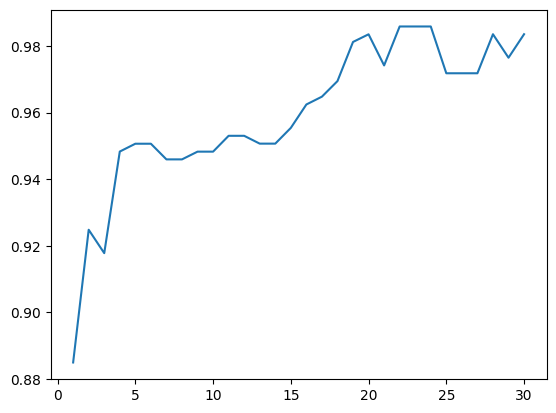

Optimal performance of  0.9858823529411765 , for  22  features


In [50]:
plt.figure()
plt.plot(np.arange(1.0,31.0,1.0),f_scores)
plt.show()

best_features = np.argmax(f_scores)
print("Optimal performance of ", f_scores[best_features],
      ", for ", best_features+1, " features")

Finally, obviously, we should evaluate the final performance 
of this model on the test set. To do this, we will first 
retrain the model on all of the training data.

In [51]:
selector = SelectKBest(chi2, k=best_features+1).fit(x_train, r_train)
select_model = tune_rescaled_logreg(selector.transform(x_train), r_train)
scoreslin = cross_val_score(select_model, selector.transform(x_train), r_train, cv=5)
print(scoreslin)
print("Average CV accuracy of linear model: ",scoreslin.mean(),", stdev: ",scoreslin.std())

select_model.fit(selector.transform(x_train), r_train)
pred_select = select_model.predict(selector.transform(x_test))

train_score_select = select_model.score(selector.transform(x_train), r_train)
test_score_select = select_model.score(selector.transform(x_test), r_test)

print("Accuracy of final model: ",train_score_select,
      " (train), ",test_score_select," (test)")

Optimal regularisation value:  1.0
[1.         0.98823529 0.95294118 1.         0.98823529]
Average CV accuracy of linear model:  0.9858823529411765 , stdev:  0.017290515831410693
Accuracy of final model:  0.9882629107981221  (train),  0.9790209790209791  (test)


Now this is what we call a linear **baseline** model, i.e., it is only the beginning. Although you only realise this when you go through the documentation, we have only tried one version of every step: there are multiple ways of rescaling, taking imbalance into account or selecting good feature sets, so even the baseline model could be tuned further. 

**Reporting requirements:** For the competition, you must always report on the following for your models:

* Which validation approach did you use: how many folds, how did you make the folds?
* Which hyperparameters did you optimise and how did you optimize them?
* For automatic approaches: what was the search strategy, what were the search ranges, for grid-search: which grid step did you use? 
* **What were the parameter values you finally selected?**
* Always nice to show a validation plot for illustration, but be selective and only show what is informative.



## Step 4: Model analysis


### Scores
When reporting on the analysis of machine learning results, the minimum is to present **train, validation and test results**. This teaches you how much you are overfitting and whether or not there may have been **information leakage** between train and validation folds (i.e. when they are NOT independent. 

**Note** that for the competition, your test score is the leaderboard score. It is calculated on a **small** subset of the test set you will recieve, which means that we have a second test set behind the scenes that will be used for computing the final scores. You should **never** use the leaderboard score for model selection. If you do, you will be overfitting on the leaderboard score. So **only use the leaderboard score to monitor whether it matches with your validation score**.

### Variability
When you are using multiple validation sets (cross-validation), reporting on the variability of the validation score is also useful. In particular when fold splits correspond to groups in the experiment (e.g., medical data from a different hospital or patient in each group). In some cases, this may teach you that the data in one of the folds is considerable more difficult than the others (not identically distributed), which may be a trigger for reinvestigating the data in that fold. Maybe something went wrong with the measurements? Or maybe this fold covers a particular situation which your model must be able to deal with and you need to put more focus on it, or try to find more data for similar situations.

### Learning curves
As mentioned before, learning curves show you how far your model has saturated to its maximal performance with the given data set. If it has saturated, and the resulting performance is not yet good enough, you may have enough data to go to a more complex model. If it is far from this convergence, you are probably overfitting too much, which may or may not result in a model with better bias, but which makes your estimates for unseen data very unreliable (high variance).

### Error analysis
The next step is to dig deeper in the errors your model makes. A good tool for this in classification tasks with more than 2 classes is to look at **confusion matrices**. This is a histogram of the true class versus the predicted class. It is usually visualised as an image, for example using the code below:

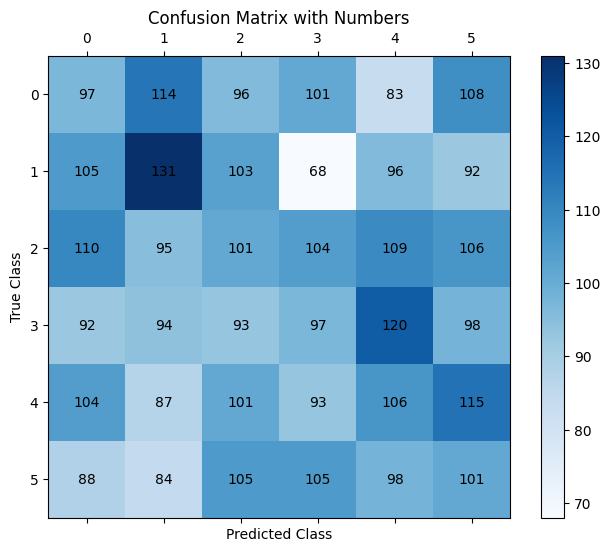

In [54]:
from sklearn.metrics import confusion_matrix

# we will use a dummy example here, since the example used in this notebook only has 2 classes
# Note that the labels used for logistic regression are class probabilities for each class, 
# whereas the code below expects integers
# so you need to convert them back to integers first, using, e.g., 
# true_class = np.argmax(r_test_class, axis=1)
# predicted_class = np.argmax(test_predicted_class, axis=1)

# below, we just generate garbage data:
# this corresponds to a uniform random classifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate random true and predicted classes for demonstration
true_class = np.random.randint(0, 6, (3600,))
predicted_class = np.random.randint(0, 6, (3600,))

# Compute confusion matrix
CM = confusion_matrix(true_class, predicted_class)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(CM)  # Use a colormap for better visual effect

# Add a color bar
plt.colorbar(cax)

# Annotate each cell with the numeric value
for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
        ax.text(j, i, CM[i, j], ha='center', va='center', color='black')

# Add labels and titles for better clarity
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('Confusion Matrix with Numbers')

plt.show()

# A more informative version can be created using the code available at:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# do check it out, since we expect your confusion matrix to contain at least some numbers.


A confusion matrix helps you to see whether your model has the same accuracy accross all classes, or whether some class pairs may be easily confused. This may help you identify dedicated approaches for addressing such class confusions. For example, if three classes are easy to extract but three others are confused a lot, one could build a two stage model that first extracts the easy classes and then uses dedicated features to separate the others. One could also build an ensemble of models with different feature sets that each specialise in different subsets of classes. 

Before building such a model, it is often useful to actually look at the data for some of the errors the model makes. This is especially true for images or time series data where human interpretation may help identifying what causes the difficulty in those cases.

## Step 5: trying out other models and improving

Afer that, you can start exploring more complex models, e.g. nonlinear models such as KNN, random forests, kernel SVM or neural networks. Or you can try to analyse the problem further and see if you could add useful features by nonlinearly transforming the ones that were provided. In all cases, any model worth considering should perform better than the baseline model. One particular model that is often worth looking at is random forests. We will quickly try it out here.

In [53]:
from sklearn.ensemble import RandomForestClassifier

# note that the max_depth parameter of the random forrest classifier
# truncates the number of features used
def tune_rescaled_RF(x_data,r_data):
    RFpipe = Pipeline([
        ('scale',RobustScaler(quantile_range=(25, 75))),
        ('RF',RandomForestClassifier(max_depth=10,n_estimators=10))
    ])

    # Set the parameters by cross-validation
    tuned_parameters = [{'RF__max_depth': [1,2,3,4,5,6,7,8,9,10]}]

    CV = GridSearchCV(RFpipe, tuned_parameters, cv=5)
    CV.fit(x_data, r_data)
    bestd = CV.best_params_['RF__max_depth']
    print("Optimal depth: ",bestd)
    optimal_RFpipe = Pipeline([
        ('scale',RobustScaler(quantile_range=(25, 75))),
        ('RF',RandomForestClassifier(max_depth=bestd))
    ])
    
    return optimal_RFpipe


modelRF = tune_rescaled_RF(x_train, r_train)
scoresRF = cross_val_score(modelRF, x_train, r_train, cv=5)
print(scoresRF)
print("Average accuracy: ",scoresRF.mean(),", stdev: ",scoresRF.std())

modelRF.fit(x_train, r_train)

train_score_RF = modelRF.score(x_train, r_train)
test_score_RF = modelRF.score(x_test, r_test)

print("Accuracy of RF model: ",train_score_RF,
      " (train), ",test_score_RF," (test)")

Optimal depth:  8
[0.95348837 0.96470588 0.91764706 0.97647059 0.97647059]
Average accuracy:  0.9577564979480163 , stdev:  0.021797762726312835
Accuracy of RF model:  1.0  (train),  0.965034965034965  (test)


In this case the random forest model has a higher training score but a lower validation and test score than our linear model: it overfits more than our linear model. However, we have not sufficiently explored the model options to completely discard it yet.

Finally, you can try to analyse the mistakes your model still makes and see whether there is anything specific about those cases. Sometimes, some of them are mislabeled data, for which the provided label is wrong and your model is right. Other times, they may be identified as outliers. In this case, they correspond to situations for which not enough examples were provided during training, so your model can not be expected to be good at them. Finally, part of the errors might be identified as a particular subset of situations that somehow behaves differently. In this case you could consider combining multiple models, one of which specializes in these special cases.